In [41]:
from IPython import display
from IPython.core.display import Image

In [42]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  

In [43]:

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
import pandas as pd
from matplotlib import cm
from matplotlib.colors import Normalize

## Group: Stanley


### Authors:
- Ana Alum Urbina 100475297 
- Alejo González García 100454351
- Alonso Madroñal de Mesa 100454449
- Andrés Navarro Pedregal 100451730
- Irina Vela Gómez 100454302

## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2023

&nbsp;
&nbsp;
&nbsp;
# Lab 4. Gaussian Processes

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />

# Diabetes dataset

[Diabetes](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset) is another classic benchmark for regression. Each observation corresponds to a diabetes patient represented by 10 variables and the corresponding target is a score that measures  the disease progression one year after baseline.

The variables that form each observation are:
- age in years

- sex

- bmi body mass index

- bp average blood pressure

- six measures taken from the blood of the patient:
  - s1 tc, T-Cells (a type of white blood cells)

  - s2 ldl, low-density lipoproteins

  - s3 hdl, high-density lipoproteins

  - s4 tch, thyroid stimulating hormone

  - s5 ltg, lamotrigine

  - s6 glu, blood sugar level


In [44]:

data = pd.read_csv('diabetes.csv', header=0)
data.columns = ['AGE', 'SEX', 'BMI', 'BP','TC','LDL','HDL','TCH','LTG','GLU','Y']
feature_names = data.columns # list with feature names
print("Feature names are")
for ii,fn  in enumerate(feature_names[:-1]):
    print("Column {0:d}: {1}".format(ii,fn))
X = data.values[:,:-1]
Y = data['Y'].values
print("")
print("Loaded {0:d} observations with {1:d} columns".format(X.shape[0], X.shape[1]))
print("Loaded {0:d} targets".format(len(Y)))


Feature names are
Column 0: AGE
Column 1: SEX
Column 2: BMI
Column 3: BP
Column 4: TC
Column 5: LDL
Column 6: HDL
Column 7: TCH
Column 8: LTG
Column 9: GLU

Loaded 442 observations with 10 columns
Loaded 442 targets


In [45]:
data.describe()

,AGE,SEX,BMI,BP,TC,LDL,HDL,TCH,LTG,GLU,Y
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,48.518100,1.468326,26.375792,94.647014,189.140271,115.439140,49.788462,4.070249,4.642700,91.260181,152.133484
std,13.109028,0.499561,4.418122,13.831283,34.608052,30.413081,12.934202,1.290450,0.521877,11.496335,77.093005
min,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,58.000000,25.000000
25%,38.250000,1.000000,23.200000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.250000,87.000000
50%,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000,140.500000
75%,59.000000,2.000000,29.275000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000,211.500000
max,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000,346.000000


# Splitting into training and test set

Divide the data set into a training set with $3/4$ of the observations.

In [46]:
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,random_state=42)

# We are going to split the data in this different way so that we can later access to the column names!
train, test = train_test_split(data,test_size=0.25,random_state=42)

X_train = train.iloc[:, :-1]
X_test = test.iloc[:, :-1]
y_train = train['Y'].values
y_test = test['Y'].values

# 1. Gaussian Process Regression initial result

Train a Gaussian Process with a composite kernel formed as:

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & {if } \mathbf x_i== \mathbf x_j \\ 0 & {otherwise} \end{array}\right.
$$
Choose the following initial parameters for these kernels:
  - RBF kernel:
     - `length_scale`= 1.5
     - `length_scale_bounds` [1e-2, 1e3]
  - White noise kernel:
     - `noise_level`=0.1
     - `noise_level_bounds` [1e-10, 1e6]
     
**Print the performance of the model in the test set.**

**Print the values of the kernel parameters after the GP optimization.**

In [47]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import *

# instantiate the kernel
constant_kernel = ConstantKernel(2) # constant_value_bounds="fixed"
# constant value fixed means than it cannot be changed during hyperparameter tuning. 

rbf_kernel = RBF(length_scale=1.5, length_scale_bounds= (1e-2, 1e3))
white_kernel  = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))

#Linearly combining
aux_kernel = constant_kernel * rbf_kernel # Compute product between Constant and RBF
custom_kernel = aux_kernel + white_kernel # Sum the Product and the White Kernel

# instantiate GP
gpr = GaussianProcessRegressor(kernel=custom_kernel, n_restarts_optimizer=10) 
# n_restarts_optimizer is the number of restarts of the optimizer for finding the
#  kernel's parameters which maximize the log-marginal likelihood. 

gpr.fit(X_train,y_train) # fitting the model

# predictions
y_pred, sigma = gpr.predict(X_test, return_std=True)
print(y_pred,y_test)

[133.97142714 177.07938046 152.54194125 277.20903811 132.80468243
 110.75721346 258.63762123 208.64414565  82.58237884 136.16586192
  99.27568901 150.06318281  77.36198431 216.77642167 103.76194064
 142.79717933 226.06986656 255.66401256 200.5759085  221.83499076
 181.17945196  78.88610786  64.88356803 197.31862857 144.17483071
 181.78176673 205.64255982 191.34753702  50.08826437 128.26176973
 175.18780977  99.64745841 132.3472277  185.92183877 150.75585707
 211.24101959 126.87888619 130.35996154 155.820152    55.39405811
  69.70863631 127.99849167 175.89160418 151.87424594 162.10813042
  72.40326288  81.58476884 102.07678525  63.35964486 135.84610575
 155.9359492   69.43948383 141.71146998  94.47523864 186.2206413
 156.25601384  92.53077511 213.63533093 102.16683247  58.16660124
 178.59437614 178.59294911 147.94048219 120.67911862 111.82305158
 191.28941746 184.14840114 170.01771252 109.38912493 146.24091563
 177.63370967 203.95862355 230.78500677 149.46096699  78.18753149
 158.664528

/home/vm/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [48]:
print(gpr.kernel_)

316**2 * RBF(length_scale=164) + WhiteKernel(noise_level=3.14e+03)


In [49]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate and print performance metrics as this can give us extra insight
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = gpr.score(X_test,y_test)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Absolute Error (MAE): 43.84622229826907
Mean Squared Error (MSE): 3048.674846646516
R-squared (R2): 0.4486716329366268


In [50]:
init_kernel_params = gpr.get_params()
opt_kernel_params = gpr.kernel_.get_params()

# Print the values of the inital kernel parameters
print("Initial Kernel Parameters:")
for param, value in init_kernel_params.items():
    print(f"{param}: {value}")


print(""); print("");  # (leave some space)
# Print the values of the optimized kernel parameters
print("Optimized Kernel Parameters:")
for param, value in opt_kernel_params.items():
    print(f"{param}: {value}")


Initial Kernel Parameters:
alpha: 1e-10
copy_X_train: True
kernel__k1: 1.41**2 * RBF(length_scale=1.5)
kernel__k2: WhiteKernel(noise_level=0.1)
kernel__k1__k1: 1.41**2
kernel__k1__k2: RBF(length_scale=1.5)
kernel__k1__k1__constant_value: 2
kernel__k1__k1__constant_value_bounds: (1e-05, 100000.0)
kernel__k1__k2__length_scale: 1.5
kernel__k1__k2__length_scale_bounds: (0.01, 1000.0)
kernel__k2__noise_level: 0.1
kernel__k2__noise_level_bounds: (1e-10, 1000000.0)
kernel: 1.41**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1)
n_restarts_optimizer: 10
n_targets: None
normalize_y: False
optimizer: fmin_l_bfgs_b
random_state: None


Optimized Kernel Parameters:
k1: 316**2 * RBF(length_scale=164)
k2: WhiteKernel(noise_level=3.14e+03)
k1__k1: 316**2
k1__k2: RBF(length_scale=164)
k1__k1__constant_value: 100000.00000000001
k1__k1__constant_value_bounds: (1e-05, 100000.0)
k1__k2__length_scale: 163.69368301719027
k1__k2__length_scale_bounds: (0.01, 1000.0)
k2__noise_level: 3140.1594359091723


### Your comments:

**Discuss about the differences between the kernel parameters before and after optimizing the GP.**

We can see that the value of R-Square is 44.8%, what means that the 44.8% of the proportion of the variance in the dependent variable is explained by the model. 
It is not bad at all, but if we take a look in the predicted value and the expected one, we can appreciate a huge difference yet. 

Between the different values of the parameters, before optimizing it uses constant value of around 2 (1.41**2), and after optimizing the value is 316 to the power of 2. 

Regarding noise levels, it goes from 0.1 to 3140, this is 4 orders of magnitude. We use a really noisy kernel. 

It is clear that we can do it better than this results. 

# 2. Strategies to improve the initial result

In this assignment we are going to explore three strategies to improve this initial result

1. Scaling the data
2. Feature selection
3. Kernel design

## 2.1 Scaling the data

Repeat the experiment that produced the baseline result scaling the observations with a `MinMaxScaler` and evaluate the impact of this scaling in the performance of the GP. 

In [51]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# "fit_transform" first fits and then transforms: 

X_train_scaled = scaler.fit_transform(X_train) 
X_test_scaled = scaler.transform(X_test)
#y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1))
#y_test_scaled = scaler.transform(y_test.reshape(-1, 1))

gpr.fit(X_train_scaled,y_train) # fitting the model with scaled data

# predictions
y_pred, sigma = gpr.predict(X_test_scaled, return_std=True)
print(y_pred,y_test)

[139.355092   176.93140213 139.91304872 287.25919403 122.33258457
  95.16711219 255.06785084 183.99443883  75.03244258 105.68628298
  99.74200429 162.49211292  74.64474234 210.3335346   97.32276515
 128.57423748 224.00945247 257.96342988 194.66720793 223.26233873
 202.48706943  90.92051829  75.82175685 195.33790456 156.28899305
 168.80066842 196.03296051 184.4949554   57.83265917 111.45565755
 178.67982527 102.18832474 125.22794189 184.21894179 168.4581304
 184.89346645 119.89701911 116.6314674  151.28530434  65.70459675
  76.24408721 115.98625678 166.74209044 156.97479182 168.3446463
  71.33740726  87.17097608 102.55338772  66.45622302 161.596604
 151.964186    79.08966231 116.04279001 107.58863601 167.50317418
 160.35957737  98.24824712 211.040505   119.85715345  68.90115643
 192.36603871 200.30749026 134.56599052 109.4228897  131.51042099
 199.37987491 164.83812659 168.4368416  125.2604876  133.13745386
 171.19268143 197.88783631 229.90675147 138.0801092   84.50718985
 152.62777135 

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate and print performance metrics as this can give us extra insight
mae_scale = mean_absolute_error(y_test, y_pred)
mse_scale = mean_squared_error(y_test, y_pred)
r2_scale = gpr.score(X_test_scaled,y_test)

print(f"Mean Absolute Error (MAE): {mae_scale}")
print(f"Mean Squared Error (MSE): {mse_scale}")
print(f"R-squared (R2): {r2_scale}")

Mean Absolute Error (MAE): 40.856661441912614
Mean Squared Error (MSE): 2706.864030205944
R-squared (R2): 0.5104853745627862


In [53]:
init_kernel_params = gpr.get_params()
opt_kernel_params = gpr.kernel_.get_params()

# Print the values of the inital kernel parameters
print("Initial Kernel Parameters:")
for param, value in init_kernel_params.items():
    print(f"{param}: {value}")


print(""); print("");  # (leave some space)
# Print the values of the optimized kernel parameters
print("Optimized Kernel Parameters with Scaling:")
for param, value in opt_kernel_params.items():
    print(f"{param}: {value}")


Initial Kernel Parameters:
alpha: 1e-10
copy_X_train: True
kernel__k1: 1.41**2 * RBF(length_scale=1.5)
kernel__k2: WhiteKernel(noise_level=0.1)
kernel__k1__k1: 1.41**2
kernel__k1__k2: RBF(length_scale=1.5)
kernel__k1__k1__constant_value: 2
kernel__k1__k1__constant_value_bounds: (1e-05, 100000.0)
kernel__k1__k2__length_scale: 1.5
kernel__k1__k2__length_scale_bounds: (0.01, 1000.0)
kernel__k2__noise_level: 0.1
kernel__k2__noise_level_bounds: (1e-10, 1000000.0)
kernel: 1.41**2 * RBF(length_scale=1.5) + WhiteKernel(noise_level=0.1)
n_restarts_optimizer: 10
n_targets: None
normalize_y: False
optimizer: fmin_l_bfgs_b
random_state: None


Optimized Kernel Parameters with Scaling:
k1: 272**2 * RBF(length_scale=3.61)
k2: WhiteKernel(noise_level=2.97e+03)
k1__k1: 272**2
k1__k2: RBF(length_scale=3.61)
k1__k1__constant_value: 73792.71168928639
k1__k1__constant_value_bounds: (1e-05, 100000.0)
k1__k2__length_scale: 3.6091199672607783
k1__k2__length_scale_bounds: (0.01, 1000.0)
k2__noise_level: 2969.

### Your comments:

**Did scaling improve the accuracy of the GP?**

**Did scaling affect to the final value of the kernel parameters after the optimization?**

It did as now the R-Squared has raised up to 51%, (6% increase), so we are explaining better the proportion of the variance of the dependent variable. 

We can see that the length scale is significantly reduced (from 164 to 3.61), 
the optimal constant is also lower, (272**2), and the noise level has been reduced a bit from the previous 3140 to 2969. 

It has been a positive result, with low effort we are getting better results. 

## 2.2 Feature selection

The goal in this strategy is to study
- if any of the variables is noisy (its presence worsens the performance of the regressors)
- if any of the variables is not relevant (its presence or absence does not affect the performance of the regressor, hence you could save resources by skipping its measure
- if some of these variables are more critical than the others in the conformation of the score. This way you can gain insights about the main drivers of the disease.

We will explore two strategies to perform the feature selection

1. Random Forests property `feature_importances_`.  

2. GP with an ARD kernel



### 2.2.1 Random Forests `feature_importances_`

In Random Forest the variables are individually selected to design the stump test in each branch node of each tree in the forest. Relevant variables will be in general oftenly selected for these test, while noisy or redundant variables will be selected less oftenly.  Besides, since the growing of each tree only considers a subset of the training data, the left-out subset can be used as validation set to evaluate the quality of each stump. In this sense, the most relevant variables will lead to better quality stumps.

In the sklearn implementation of Random Forest there is a property `feature_importances_` that is precisely a score in the relevance of the features.


In the following cell write code that
 1. Train a Random Forest Regressor with its hyperparameters selected by cross-validation within the following  ranges
  - number of trees: 10, 20, 50, 100, 200, 500, 1000
  - maximum number of leaves per node: 5, 10, 20, 50
  
 2. Print the score in the test set  of the Random Forest fitted with the best set of hyperparameters
 
 3. Print the value of `feature_importances_` for each feature in the data set
 
 4. Sort the features in order of decreasing importance in an array called `random_forest_order`
 
 

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

n_trees = [10,20,50,100,200,500,1000]
max_leaves_per_node = [5, 10,20,50]

param_rf= {"max_leaf_nodes": max_leaves_per_node, "n_estimators": n_trees} 

grid_rf = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_rf, cv = 5)
grid_rf.fit(X_train, y_train)



GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_leaf_nodes': [5, 10, 20, 50],
                         'n_estimators': [10, 20, 50, 100, 200, 500, 1000]})

In [55]:
print(grid_rf.best_params_)
print(grid_rf.score(X_test, y_test))

best_forest = grid_rf.best_estimator_
print(best_forest)

best_rf = RandomForestRegressor(max_leaf_nodes=20, n_estimators=50)
best_rf.fit(X_train, y_train)
print(best_rf.score(X_test, y_test))

{'max_leaf_nodes': 20, 'n_estimators': 1000}
0.495855352452903
RandomForestRegressor(max_leaf_nodes=20, n_estimators=1000)
0.485520047543174


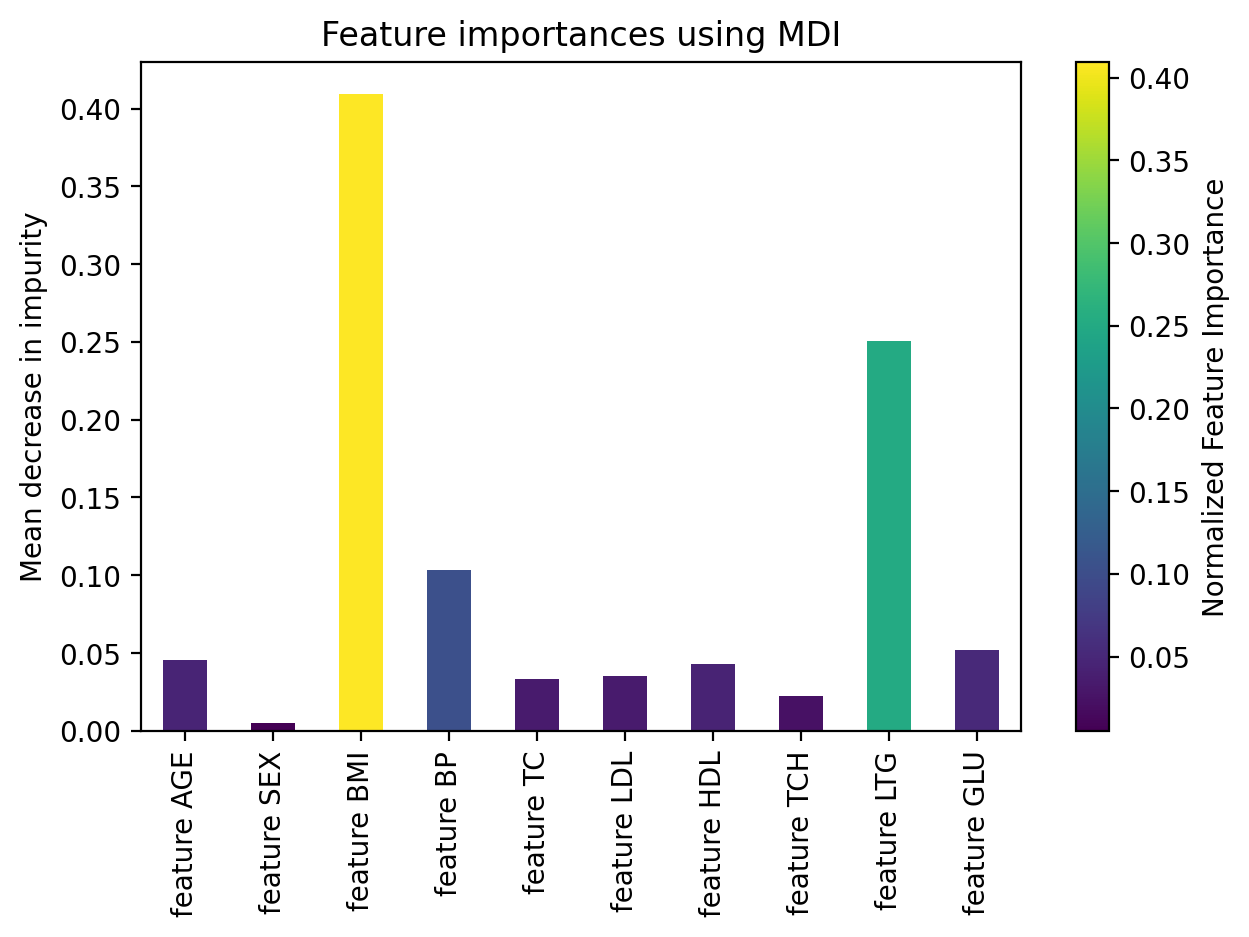

feature AGE    0.045542
feature SEX    0.005105
feature BMI    0.409329
feature BP     0.103151
feature TC     0.033613
feature LDL    0.035020
feature HDL    0.043050
feature TCH    0.022639
feature LTG    0.250787
feature GLU    0.051765
dtype: float64


In [56]:
importances = (best_forest.feature_importances_)
feature_names = [f"feature {i}" for i in X_train.columns]
forest_importances = pd.Series(importances, index=feature_names)

norm = Normalize(vmin=forest_importances.min(), vmax=forest_importances.max())
#Assing a normalized score to each one of the importances
# Create a color map based on the normalized values
colors = cm.viridis(norm(forest_importances))

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, color=colors)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
mappable.set_array(norm(forest_importances))
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical')
cbar.set_label("Normalized Feature Importance")

plt.show()
print(forest_importances)

In [57]:
y_pred = grid_rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
r2_rf = grid_rf.score(X_test, y_test)

print(f"GP Scaled: \n Mean Absolute Error (MAE): {mae_scale}")
print(f"Mean Squared Error (MSE): {mse_scale}")
print(f"R-squared (R2): {r2_scale}\n")


print(f"Random Forest: \n Mean Absolute Error (MAE): {mae_rf}")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")

GP Scaled: 
 Mean Absolute Error (MAE): 40.856661441912614
Mean Squared Error (MSE): 2706.864030205944
R-squared (R2): 0.5104853745627862

Random Forest: 
 Mean Absolute Error (MAE): 42.04263312649013
Mean Squared Error (MSE): 2787.763514210105
R-squared (R2): 0.495855352452903


### Your comments:

**Did RF perform in the test set better than GP?**

**What are the more relevant features according to RF?**

**Are there significant differences in relevance among the features?**



- If regarding performance we account for the R-Squared, we can see that the R-Squared of the Scaled data is about 2% higher than the one with Random Forest. 
The MSE has increased also a bit (not too significant), an so does the MAE. 

- If our target is to use simpler data, we can use Random Forests, that do this feature selection for us, sacrificing some R-Squared but reducing the number of variables and the noise. 

- Despite this small reduce in performance, by simply checking the plot we have acknowledge that the BMI and LTG are the most important feautres in our data set, which means that those are the variables that provided the best information. 
Thanks to this, we can also reduce the noise of our input data as it is no longer needed to keep those variables that are not significant enough for us. (SEX or TCH for example).  

- While BMI and LTC score 0.2~0.3 points over the rest of features; LDL, HDL, TC and THC score almost the same. The SEX feature is almost negligible. So yes, there are significant differences among the features. 

In the next cell write code that implements a `for loop` that in each iteration trains a GP with the settings of Section 1 but increasing the number of features in the ordering suggested by `random_forest_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [58]:

importances = best_forest.feature_importances_
feature_names = X_train.columns

# Combining importances and feature names using zip
feature_importance_tuples = list(zip(feature_names, importances))

# Sort the tuples based on importances (in descending order)
sorted_feature_importance_tuples = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)

# Unpack the sorted tuples into separate lists
sorted_feature_names, sorted_importances = zip(*sorted_feature_importance_tuples)

# Print the sorted feature names and importances
print("Sorted Feature Names:", sorted_feature_names)
print("Sorted Importances:", sorted_importances)


Sorted Feature Names: ('BMI', 'LTG', 'BP', 'GLU', 'AGE', 'HDL', 'LDL', 'TC', 'TCH', 'SEX')
Sorted Importances: (0.4093285545166911, 0.2507873986261678, 0.10315098627624512, 0.051764928856959366, 0.0455416441011475, 0.04304988570294041, 0.03501983032751575, 0.03361310252350229, 0.022638510174935855, 0.005105158893894794)


In [59]:
import warnings
scores = np.zeros(len(sorted_feature_names))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(sorted_feature_names, start=0):
        selected_features = list(sorted_feature_names[:(i+1)])
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        gaussian_process = GaussianProcessRegressor(kernel=custom_kernel, n_restarts_optimizer=10)
        gaussian_process.fit(X_train_subset, y_train)
        score = gaussian_process.score(X_test_subset, y_test)
        scores[i] = score


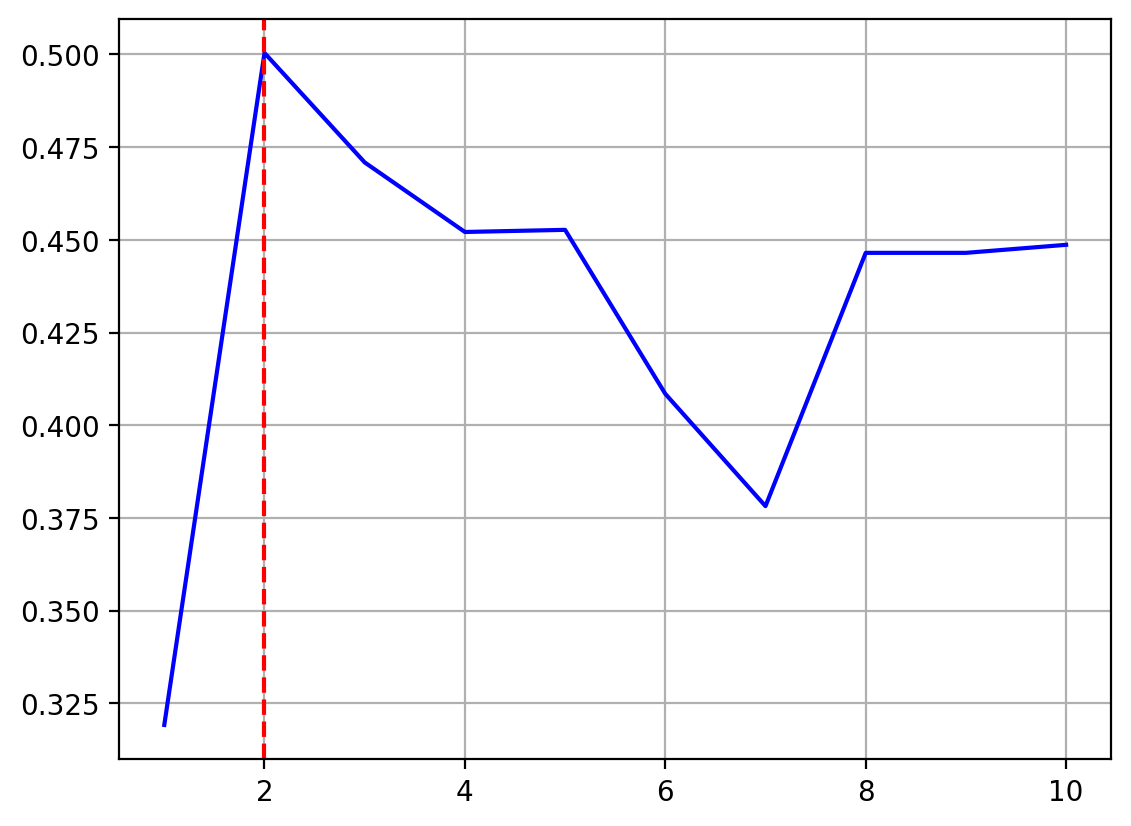

In [60]:
xaxis = np.linspace(1,10, 10)
plt.figure()
ax.set_title("Score given number of features")
plt.plot(xaxis, scores, label='mean fitting time', color='blue')
plt.axvline(x=2, color='red', linestyle='--', label='Vertical Line at x = 2')
plt.grid(True)  
plt.show()

### Your comments:

**What is the best number of features to model the problem?**

**Does removing features improve the performance of RF?**

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**



- The model R-Squared peaks when we have one or two variables, this is because we have selected the most important variables from the random forest. However as we increase the number of variables the performance decreases. These are noisy features, they can be easily seen in the graph, after the 6th variable our R-Squared coefficient decreases quickly. These noisy variables are LDL, TC, TCH or SEX. As seen in the barchart they are not relevant.

- A model with just 2 variables is easy to interpret and is less computer intensive.


### 2.2.2 GP with an ARD kernel

The fitting of a GP endowed with an anisotropic RBF kernel obtains a different value of the `length_scale` for each variable.

**Relate the length scale of each variable with its relevance in the predictive function**

Hint: Consider how does the output of the predictive function change as the value of a certain variable $x_k$ changes depending on $l_k^2$.

In the next cell write code that fits a GP with an ARD kernel. 

**Print the lengthscale value of each feature after the kernel has been optimized** Hint, learn to use `kernel_get_params()`.** 

**Sort the features in order of decreasing importance in an array called `ARD_order`**

**Print the score in the test set  of the GP with ARD kernel**

In [61]:
length_scales = (1e-2,1e3)

# instantiate the kernel
constant_kernel = ConstantKernel(2) 
rbf_kernel = RBF(length_scale = 2*np.ones(10), length_scale_bounds=length_scales)

white_kernel  = WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-10, 1e6))

#Linearly combining
aux_kernel = constant_kernel * rbf_kernel # Compute product between Constant and RBF
custom_kernel = aux_kernel + white_kernel # Sum the Product and the White Kernel

# instantiate GP
gpr_ansiotropic = GaussianProcessRegressor(kernel=custom_kernel) 

gpr_ansiotropic.fit(X_train,y_train) # fitting the model

# predictions
y_pred, sigma = gpr_ansiotropic.predict(X_test, return_std=True)
print(y_pred,y_test)

[143.71023284 181.39171036 142.44705096 279.74686916 122.99499837
  94.42757873 270.25185518 194.7897576   93.95164007 112.66612934
  99.32533724 162.8525724   71.01290425 208.04953423 101.62178993
 128.09427796 221.79247384 254.46049306 198.32031905 220.71548036
 204.18193972  93.7375463   68.9534128  195.06476286 154.54690427
 165.47044171 199.05989542 176.89948608  60.74806435 114.98387752
 175.56162986  92.8261539  130.83128731 181.33014456 167.66346593
 207.14508999 124.91677007 121.28860459 143.71661362  65.85866494
  75.31844969 104.12203699 165.79250181 142.90209819 170.89921602
  65.38213765  80.39551476  99.35116445  69.0088109  158.40154801
 150.02284625  81.21245687 109.01752271 105.87280908 173.6368717
 156.53122488  95.38964742 215.71378365 119.54628514  66.90959311
 190.55635023 201.41289575 136.76097812 103.90122567 129.77284732
 209.83510389 171.63743339 166.90349388 120.87673797 144.22227251
 181.53646576 198.42801804 221.08550976 145.88091077  86.82129914
 151.596533

/home/vm/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/vm/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 4 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/vm/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/vm/.local/lib/python3.10/site-packages/sklearn/gaussian_proce

In [62]:
kernel_params = gpr_ansiotropic.kernel_.get_params()
length_scales_optimized = kernel_params['k1__k2__length_scale']
for i, length_scale in enumerate(length_scales_optimized):
    print(f"Feature {i + 1}: {length_scale}")

Feature 1: 999.9999999999998
Feature 2: 9.55813954660673
Feature 3: 31.108175903678745
Feature 4: 158.62389264793532
Feature 5: 999.9999999999998
Feature 6: 999.9999999999998
Feature 7: 160.39870633438065
Feature 8: 999.9999999999998
Feature 9: 4.453805153842333
Feature 10: 999.9999999999998


In [63]:
feature_names = X_train.columns
feature_importance_tuples = list(zip(feature_names, importances))
sorted_feature_importance_tuples = sorted(feature_importance_tuples, key=lambda x: x[1], reverse=True)
ARD_order, sorted_importances = zip(*sorted_feature_importance_tuples)
print("Sorted Feature Names:", ARD_order)
print("Sorted Importances:", sorted_importances)

Sorted Feature Names: ('BMI', 'LTG', 'BP', 'GLU', 'AGE', 'HDL', 'LDL', 'TC', 'TCH', 'SEX')
Sorted Importances: (0.4093285545166911, 0.2507873986261678, 0.10315098627624512, 0.051764928856959366, 0.0455416441011475, 0.04304988570294041, 0.03501983032751575, 0.03361310252350229, 0.022638510174935855, 0.005105158893894794)


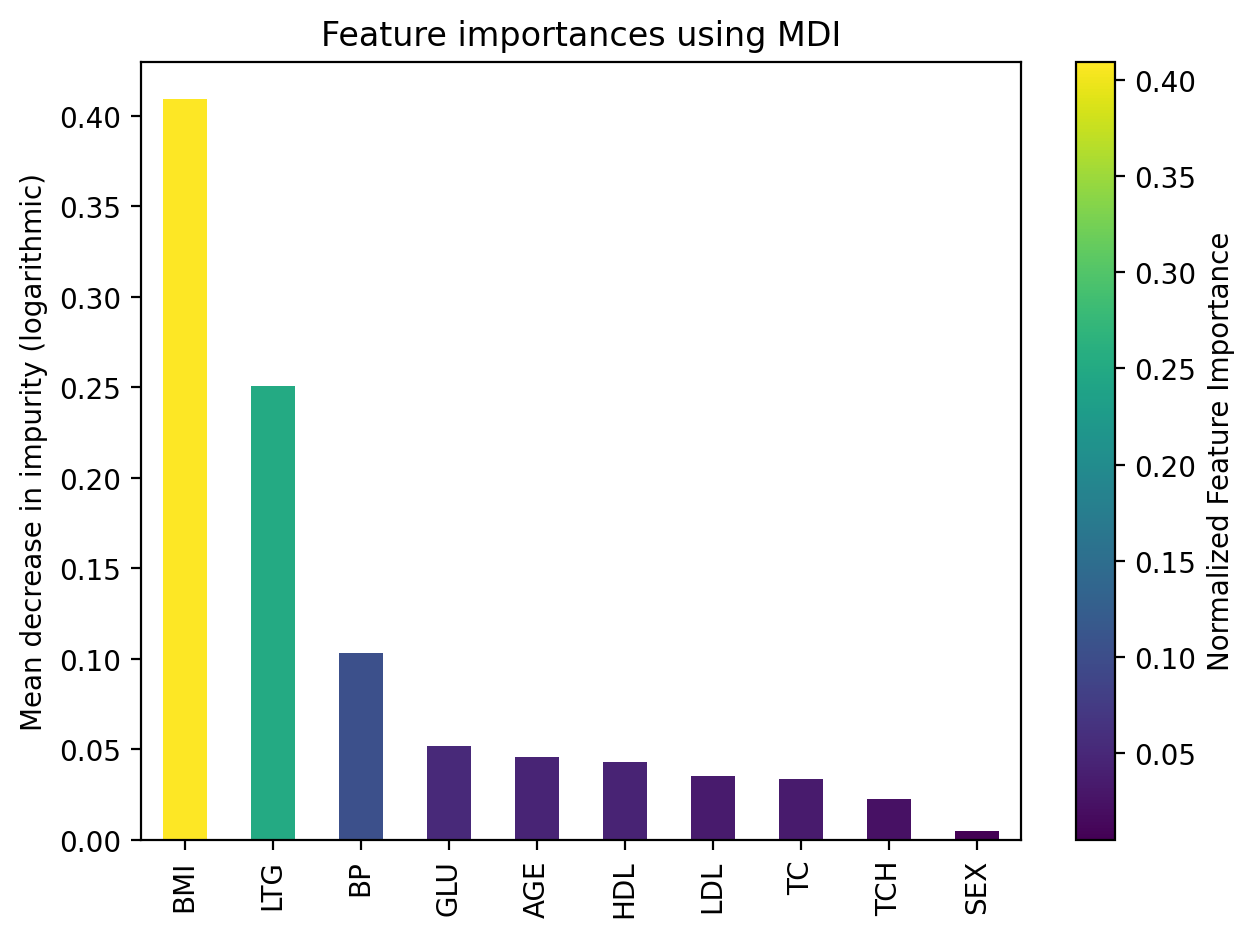

In [64]:
#Defining variables
importances = length_scales_optimized
feature_names = [f"feature {i}" for i in X_train.columns]
forest_importances = pd.Series(sorted_importances, index=ARD_order)

#creating the color map
norm = Normalize(vmin=forest_importances.min(), vmax=forest_importances.max()) #Adding a normalized score to each one of the importnces
colors = cm.viridis(norm(forest_importances))
#Plotting
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax, color=colors)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity (logarithmic)")
fig.tight_layout()
#Adding a legend
mappable = cm.ScalarMappable(norm=norm, cmap=cm.viridis)
mappable.set_array(norm(forest_importances))
cbar = plt.colorbar(mappable, ax=ax, orientation='vertical')
cbar.set_label("Normalized Feature Importance")
plt.show()

In [65]:
gpr_ansiotropic.score(X_test, y_test)

0.511201312732853

In [66]:
kernel_params = gpr_ansiotropic.kernel_.get_params()
kernel_params

{'k1': 189**2 * RBF(length_scale=[1e+03, 9.56, 31.1, 159, 1e+03, 1e+03, 160, 1e+03, 4.45, 1e+03]),
 'k2': WhiteKernel(noise_level=2.97e+03),
 'k1__k1': 189**2,
 'k1__k2': RBF(length_scale=[1e+03, 9.56, 31.1, 159, 1e+03, 1e+03, 160, 1e+03, 4.45, 1e+03]),
 'k1__k1__constant_value': 35647.25826724792,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': array([1000.        ,    9.55813955,   31.1081759 ,  158.62389265,
        1000.        , 1000.        ,  160.39870633, 1000.        ,
           4.45380515, 1000.        ]),
 'k1__k2__length_scale_bounds': (0.01, 1000.0),
 'k2__noise_level': 2971.6565156205033,
 'k2__noise_level_bounds': (1e-10, 1000000.0)}

In the next cell write code that implements a `for loop` that in each iteration trains a GP with an ARD kernel but increasing the number of features in the ordering suggested by `ARD_order`. 

Plot the GP accuracy in the test set vs. the number of features used to model the problem.

In [67]:
#length_scales = np.linspace(1e-2, 1e3, 10)

scores = np.zeros(len(ARD_order))
noise_level = np.zeros(len(ARD_order))


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, feature in enumerate(ARD_order, start=0):
        selected_features = list(ARD_order[:(i+1)])
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        rbf_kernel = RBF(length_scale = 2*np.ones(i+1), length_scale_bounds=length_scales)

#        rbf_kernel = RBF(length_scale=1.5, length_scale_bounds=length_scales)
        aux_kernel = constant_kernel * rbf_kernel
        custom_kernel = aux_kernel + white_kernel
        
        gpr_ansiotropic = GaussianProcessRegressor(kernel=custom_kernel, n_restarts_optimizer=10)
        gpr_ansiotropic.fit(X_train_subset, y_train)
        scores[i] = gpr_ansiotropic.score(X_test_subset, y_test)
        ker_par = gpr_ansiotropic.kernel_.get_params()
        noise_level[i] = ker_par['k2__noise_level']

In [68]:
print(length_scales)

(0.01, 1000.0)


The length_scale parameter controls the width of the Gaussian distribution used to model the similarity between data points. It determines how far apart data points need to be in order to be considered similar. 

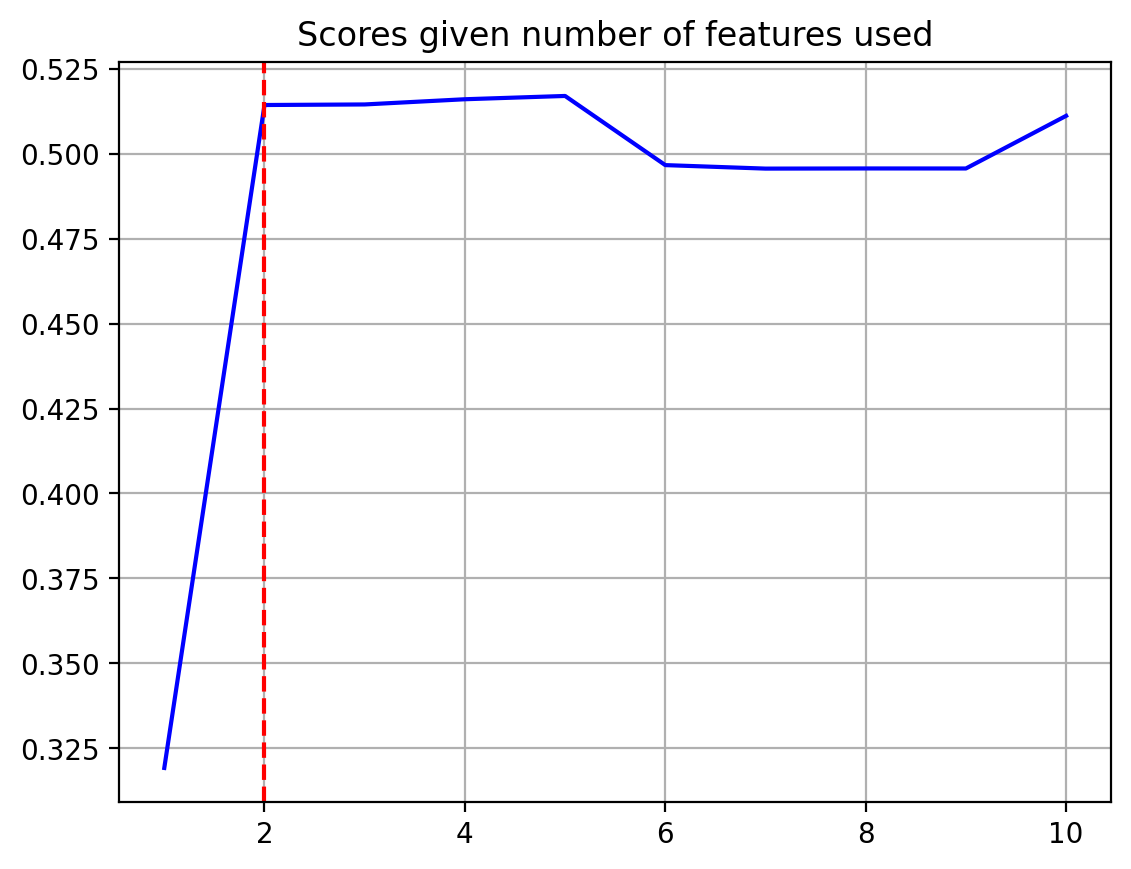

In [69]:
plt.figure()
plt.title("Scores given number of features used")
plt.plot(xaxis, scores, label='mean fitting time', color='blue')
plt.axvline(x=2, color='red', linestyle='--', label='Vertical Line at x = 2')
plt.grid(True)  
plt.show()

We can see that the R-Squared, the score, increases with the number of features up to some point that we can decide. We have placed the threshold in 2 features but it could be a different one like 3. 

This matches the same result that we got with Random Forest, so we are confident about using only 2 variables instead of the whole data set as it is much simpler.  

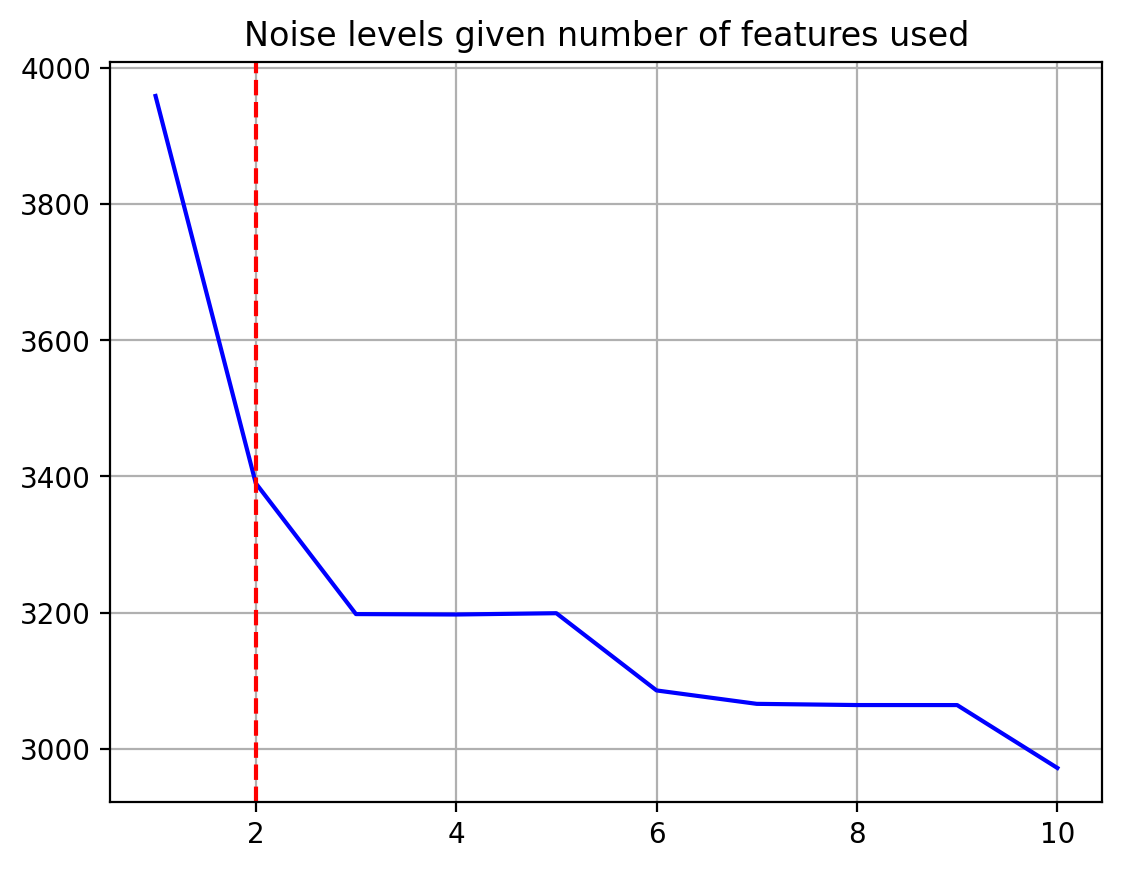

In [70]:
plt.figure()
plt.title("Noise levels given number of features used")
ax.set_title("Mean fitting time")
plt.plot(xaxis, noise_level, label='mean fitting time', color='blue')
plt.axvline(x=2, color='red', linestyle='--', label='Vertical Line at x = 2')
plt.grid(True)  
plt.show()

We can see that for larger number of features, in most of the cases, the noise decreases, as every new variable adds at least some sort of explanation to the variability of the data. 

However we must look at the slope with which the noise decreases, and here we see again that for 2 or 3 features we get good results already. 

### Your comments:

**What is the best number of features to model the problem according to the ARD kernel?**

**How stable are the optimizations of the Gaussian Processes with ARD kernels as the number of features increase?**

**Does removing features improve the performance of GPs?**

**Are there noisy features? (Features that, if present, significantly worsen the performance of the GP)**

**How does the feature selection suggested by the ARD kernel compare with that suggested by random forest?**

- The best number of features to model according with the ARD kernel seems to be between 2 and 4. When comparing the features selected with respect to the random forest we see that they coincide in some such as the BMI or the LTG, which we think are the most important ones. After 4 is clear that the performance gets worse (no more important features).

- After the 4th feature mark the length scale of the RBF kernel stabilizes. This may be because it has found the optimal value after the features are added. It could also mean that after the 2 optimal features the RF showed us, the length scale has to adapt to the noisier variables.

- Yes, as we can see the performance gets significantly better the less features we use, peaking between 2 and 4. Meaning that the variables the model deemed less relevant are noisy and not that useful and they are simpler models that are always easier to work with. 

- When determining the more noisy variables the Random Forest and the GPR coincide, variables such as SEX, AGE, or TC barely add any information. These variables are noisy and shold not be used, as they make the model worse.

# 4. Exploring sophisticate kernels for the GP

The greatest potentiality of GPs are the exploration of different kernels that capture the geometry of the inputs. 

Besides, the essential kernels can be combined into more sophisticate ones using the addition and multiplication operations.

And the most interesting feature, the GP implementation is able to optimize the parameters of the kernel maximizing the likelihood of the observations, what saves the crossvalidation step for optimizing parameters.

Read the [section 1.7.5 of this site](https://scikit-learn.org/stable/modules/gaussian_process.html) to learn the different kernels that are implemented in the scikit learn distribution of Gaussian Processes.

In this section check at least twenty different kernel configurations and evaluate if they improve the kernel evaluated in section 1. Remember this kernel was

$$
\kappa_1(\mathbf x_i, \mathbf x_j) = \kappa_c(\mathbf x_i, \mathbf x_j)\times\kappa_r(\mathbf x_i, \mathbf x_j) + \kappa_w(\mathbf x_i, \mathbf x_j)
$$ where
- $\kappa_c(\mathbf x_i, \mathbf x_j)$ is a constant kernel
- $\kappa_r(\mathbf x_i, \mathbf x_j)$ is an isotropic RBF kernel with length_scale $l$: 
$$
\kappa_r(\mathbf x_i, \mathbf x_j) = \exp\left( -\frac{\|\mathbf x_i - \mathbf x_j\|^2}{2l^2}\right)
$$
- $\kappa_w(\mathbf x_i, \mathbf x_j)$ is a WhiteKernel that explains the additive noise component
$$
\kappa_w(\mathbf x_i, \mathbf x_j) = \left \{ \begin{array}{ll} \sigma_n^2 & \mbox{if } \mathbf x_i== \mathbf x_j \\ 0 & \mbox{otherwise} \end{array}\right.
$$

Within the kernel combinations to explore you can include:
1. Replace $\kappa_r(\mathbf x_i, \mathbf x_j)$ by an anisotropic RBF in $\kappa_1(\mathbf x_i, \mathbf x_j)$. 

3. Individual kernels presented in the lecture

4. Addition of several kernels

5. Multiplication of several kernels

6. Use your imagination!

We will use the different kernel combinations to characterize how difficult is the problem at hand in terms of how difficult is to find out a kernel that achieves the best possible result in the test set.

For this purpose:
1. Group in a same array all the scores in the **test set** achieved by all the kernel combinations that you explore in this section. Consider carrying out this exploration in a programatic fashion. As a suggestion, program nested loops that create composite kernels as combination of simple kernels.

2. Discuss about the range of test accuracies that can be reached with GPs when the kernel is more carefully designed. Depending on the number of different kernels explored you might consider adding to your discussion
- minimum, maximum, mean values
- standard deviations
- percentiles
- histogram

In [71]:
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic, ExpSineSquared

kernel_list = np.array([
    ConstantKernel(constant_value=50.0),
    RBF(length_scale=1.5, length_scale_bounds= (1e-2, 1e3)),
    WhiteKernel(noise_level=0.1, noise_level_bounds=[1e-10, 1e6]),
    Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e3), nu=1.5),
    RationalQuadratic(length_scale=1.0, alpha=0.5)
])
scores = np.zeros(len(kernel_list)**3)
maes = np.zeros(len(kernel_list)**3)
mses = np.zeros(len(kernel_list)**3)
model_params = []

In [72]:
for i, kernel in enumerate(kernel_list):
    for j, k in enumerate(kernel_list):
        for l, aux in enumerate(kernel_list):
            a = Product(kernel_list[l], kernel_list[j])
            b = Sum(a, kernel_list[i])
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = GaussianProcessRegressor(kernel=b, n_restarts_optimizer=10)
                model.fit(X_train, y_train)
                scores[i*25+j*5+l] = model.score(X_test, y_test)
                model_params.append(model.kernel_.get_params())
                y_pred, sigma = gpr.predict(X_test, return_std=True)
                maes[i*25+j*5+l] = mean_absolute_error(y_pred, y_test)
                mses[i*25+j*5+l] = mean_squared_error(y_pred, y_test)
                

In [73]:
print(min(scores), max(scores))

-3.8306034723419673 0.4486716405826585


In [74]:
model_params[np.where(scores == max(scores))[0][0]]
#in order to see what the best model, the one with the best accuracy has as parameters

{'k1': 316**2 * RBF(length_scale=164),
 'k2': WhiteKernel(noise_level=3.14e+03),
 'k1__k1': 316**2,
 'k1__k2': RBF(length_scale=164),
 'k1__k1__constant_value': 100000.00000000001,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2__length_scale': 163.69350228122423,
 'k1__k2__length_scale_bounds': (0.01, 1000.0),
 'k2__noise_level': 3140.1628520424188,
 'k2__noise_level_bounds': [1e-10, 1000000.0]}

# Items for discussion
- Which strategy turned out to be the best in terms of increasing the performance of the GP? 
- Did this strategy performed significantly better than the others?
- Kernel design pushes the GP model further into the **black box method** region, what is the price you pay for sticking to the more interpretable ARD kernel in terms of accuracy? 

- It seems that the better strategy was one of the initial ones, multiplying a constant kernel times an ansiotropic and adding a noise kernel. It still goes out of bounds but we get a R-Squared coefficient of 0.5 more or less. Note that at the beggining, scaling gave us a R-Squared of around 51% that is considerably good. 

- It does not perform significantly better than the others; however, if we are comparing to all the new strategies implemented, then yes it is way more accurate. 

- Black boxing gives better results at the cost of interpretability. It often happens in ML that there is no free lunch and predictive power always comes at a cost. Regarding accuracy, if we know what we are using, by understanding the model completly we can maybe tune some specific parameter increase the accuracy. 